##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<h4>下载模型和数据</h4>

<h5>下载</h5>

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -O ../models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip

<h5>准备数据</h5>

In [ ]:
import os
from zipfile import ZipFile
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('../data')
zip_ref.close()

<h4>导包，初始化</h4>

<h5>导包</h5>

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, TensorBoard, History
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.backend import clear_session
from tensorflow.compat.v1 import reset_default_graph

<h5>初始化</h5>

In [2]:
clear_session()
reset_default_graph()
# 设置显存自动增长
physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, enable=True)

<h4>加载模型</h4>

<h5>预训练模型</h5>

In [3]:
local_weights_file = '../models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), 
    include_top=False, 
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

<h5>迁移模型</h5>

In [8]:
# Flatten the output layer to 1 dimension
x = Flatten(name="flatten_8")(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(units=1024, activation='relu', name="dense_8")(x)
# Add a dropout rate of 0.2
x = Dropout(rate=0.2, name="dropout_9")(x)                  
# Add a final sigmoid layer for classification
x = Dense(units=1, activation='sigmoid', name="dense_9")(x)           

model = Model(
    inputs=pre_trained_model.input, 
    outputs=x,
    name="transfered_inception_v3"
) 

model.compile(
    optimizer = RMSprop(lr=0.0001), 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)

model.summary()

Model: "transfered_inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________

<h4>训练模型</h4>

<h5>准备数据</h5>

In [10]:
# Define our example directories and files
base_dir = '../data/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# 训练集数据增强
train_datagen = ImageDataGenerator(
    rescale=1./255.,             # 标准化
    rotation_range=40,           # 旋转范围
    width_shift_range=0.2,       # 水平平移范围
    height_shift_range=0.2,      # 垂直平移范围
    shear_range=0.2,             # 倾斜范围
    zoom_range=0.2,              # 缩放范围
    horizontal_flip=True,       # 允许水平翻转
    fill_mode="nearest"          # 填充方式为就近原则
)

# 验证集数据不增强
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary', 
    target_size=(150, 150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( 
    validation_dir,
    batch_size=20,
    class_mode='binary', 
    target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h5>开始训练</h5>

In [12]:
history: History = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps = 50,
    epochs = 20,
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/20
100/100 [==============================] - 18s 178ms/step - loss: 0.3544 - accuracy: 0.8595 - val_loss: 0.1077 - val_accuracy: 0.9570
Epoch 2/20
100/100 [==============================] - 14s 138ms/step - loss: 0.1997 - accuracy: 0.9200 - val_loss: 0.1197 - val_accuracy: 0.9550
Epoch 3/20
100/100 [==============================] - 14s 139ms/step - loss: 0.1984 - accuracy: 0.9290 - val_loss: 0.1391 - val_accuracy: 0.9560
Epoch 4/20
100/100 [==============================] - 14s 140ms/step - loss: 0.2112 - accuracy: 0.9350 - val_loss: 0.0983 - val_accuracy: 0.9670
Epoch 5/20
100/100 [==============================] - 14s 139ms/step - loss: 0.1761 - accuracy: 0.9355 - val_loss: 0.1058 - val_accuracy: 0.9660
Epoch 6/20
100/100 [==============================] - 14s 140ms/step - loss: 0.1902 - accuracy: 0.9365 - val_loss: 0.1075 - val_accuracy: 0.9680
Epoch 7/20
100/100 [==============================] - 14s 141ms/step - loss: 0.1808 - accuracy: 0.9335 - val_loss: 0.1242 - val_ac

<h4>画图</h4>

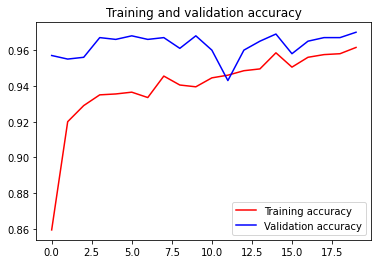

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()